# Introduction
This notebook implements Linear Regression. There are two implementations. The first implementation uses the exact formula. The second implementation uses Gradient Descent. 

- Algorithms: Linear Regression (Exact and Gradient Descent)
- DataSets:   "linear_regression" and "breast_cancer_2d".
- Video: To Be Added.


# Linear Regression
The hypothesis set for linear regression is 

$$ H = \{ h(x)=w^Tx \mid w\in \mathbb{R}^{d+1}\} $$

Given data $D=\{(x_1, y_1), ..., (x_N, y_N)\}$ we want to minimize the following error function  

$$E_{in}(h)=\frac{1}{N}\sum_{i=1}^N (h(x_i)-y_i)^2$$

Notice that any hypothesis $h(x)=w^Tx\in H$ is described exactly by its weights $w\in R^{d+1}$. Our goal is to find weights $w$ such that we minimize the in-sample error $E_{in}(w)$. We shall later prove that the following $w^*$ minimizes the above error $E_{in}$

$$w^* = (X^TX)^{-1}X^Ty$$

where $X$ is $n\times d$ matrix with the $i$'th datapoint $x_i$ on the $i$'th row

$$X=\begin{pmatrix}- & x_1^T & - \\ & \vdots & \\ - & x_N^T & - \end{pmatrix}\in \mathbb{R}^{n \times d}$$

In the code below we use this as a fact and postpone the proof until later in this notebook. Run the following code, it will visualize the data we will use. 

<IPython.core.display.Javascript object>


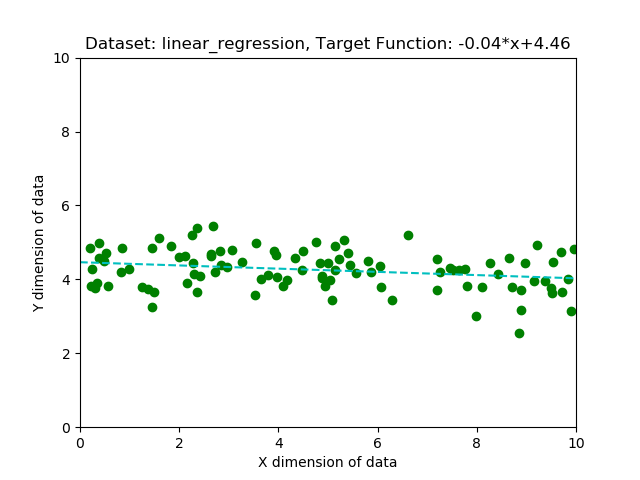

In [1]:
import ipython_import_class
import DataSet as ds

data = ds.DataSet("linear_regression", 100)
data.plot_regression() 

The dashed line is the real target function used to generate the data. The data is noise and will lie around the real target. Our goal is to reconstruct the target function using only the data.

# Code: Linear Regression
The following class implements the class `LinearRegression`. 

In [ ]:
import ipython_import_class
import DataSet as ds
import numpy as np
import matplotlib.pyplot as plt
import hide_visualization_code

class LinearRegression:
    
    def __init__(self, visualize=False):
        self.visualize = visualize
        if self.visualize:
            self.fig, self.ax_data = plt.subplots(1, 1, figsize=(9, 5))
            self.xlim = None
            self.ylim = None
    
    def fit(self, X, y):
        pseudo_inverse = np.linalg.inv( X.T @ X ) @ X.T
        self.w = pseudo_inverse @ y
        
        if self.visualize: self.do_visualize(X, y)
    
    def predict(self, X):
        return X @ self.w
    
    def error(self, X, y):
        """ Least Squares Error """
        n, d = X.shape
        pred = self.predict(X)
        diff = pred - y
        error = 1/n * np.sum(diff**2)
        return error
    
    def do_visualize(self, X, y):
        hide_visualization_code.visualize_linreg(self, X, y)
        
    def __str__(self):
        return str(round(self.w[1], 3)) + "*x+" + str(round(self.w[0], 3))

Let's try to run Linear Regression on the dataset! I have written code that will visualize the result. Notice that the algorithm has exactly one step. 

In [ ]:
data = ds.DataSet("linear_regression")

linreg = LinearRegression(visualize=True)
linreg.fit(data.X, data.y)

# Print error and the unkown target function vs the least squares fit. 
print("Least Squares Error: \t", linreg.error(data.X, data.y))
print("Unknown Target Function: ", data.target_function)
print("Least Squares Fit: \t", linreg)

Notice that the hypothesis Linear Regression gives us (our least square fit) is pretty close to the original unknown target function!

<div style="border: 1px solid black; padding: 16px; "><b>Observation</b>: Typically one thinks of learning/training as an iterative process. This is not the case for exact Linear Regression where the weights $w^*$ are computed in one step! This might be a bit confusing, but from a Machine Learning viewpoint this is still learning. </div> 

# Time Budget for exact Linear Regression 
Remember the formula we used to find our weights

$$w^* = (X^TX)^{-1}X^Ty$$

What is the <a href="https://en.wikipedia.org/wiki/Time_complexity" target="_new">time complexity</a> of evaluating this formula? 

The matrix $X$ has dimension $n\times d$ and the vector $y$ has dimensions $n\times 1$. For simlicitly let's assume matrix inversion takes $O(n^3)$ time. 


<table>
<tr>
<td><b>Operation</b></td>
<td><b>Cost</b></td>
</tr>

<tr>
<td>Multiply $X^T$ and $X$</td>
<td>$d^2 n$</td>
</tr>

<tr>
<td>Invert $X^TX$</td>
<td>$d^3$</td>
</tr>

<tr>
<td>Multiply $(X^TX)^{-1}$ and $X^T$</td>
<td>$d^2n$</td>
</tr>

<tr>
<td>Multiply $(X^TX)^{-1}X^T$ and $y$</td>
<td>$dn$</td>
</tr>

<tr>
<td>Sum</td>
<td>$d^2n+d^3+d^2n+dn$</td>
</tr>

<tr>
<td><a href="https://en.wikipedia.org/wiki/Big_O_notation" target="_new">Big-O notation</a></td>
<td>$O(d^2n+d^3)$</td>
</tr>
</table>

If $d>n$ this will take very long time. This means our data has more dimensions than number of data points. This might not happen that often, but there is a very nice way to speed up our algorithm if this happens. The bottleneck of the computation is inverting $X^TX$ which takes $d^3$ time which is at least $n^3$ assuming $d>n$. In the following section we investigate how to circumvent this by using Gradient Descent. 

# Linear Regression (Gradient Descent)
Remember that we are trying to find a $w$ that minimizes the following error function

$$E_{in}(w)=\sum_{i=1}^N (w^Tx_i-y_i)^2$$

Imagine that our error function looks like

<img src="https://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization_files/ball.png" style="width: auto; height: 200px; " />

The x-axis represents different weights $w$ and the y-axis represents the in-sample error of such $w$. By using the formula for $w^*$ we were able to find the $w$ at the bottom of the parabola. 

Instead of using the formula we will use an algorithm called Gradient Descent. You can think of Gradient Descent as dropping a ball at a random point on the parabola. The ball would then slide towards the bottom and give us a good solution! The ball might not end exactly at the bottom, but it will often get close enough. 

This all sounds great. But just how do we drop a ball on our error function?! Remember our error function was 

$$E_{in}(h)=\sum_{i=1}^N (h(x_i)-y_i)^2$$

We shall later prove that the gradient of this error function is

$$\nabla_w E_{in}(w)=\frac{2}{N}\left(X^TXw-X^Ty\right)$$

Gradient Descent then does the following: make an initial guess on $w$, compute the gradient of our error and iteratively update $w$ in the negative direction of the gradient. The following pseudocode gives a more complete picture

    w = initialize random
    for i=1,...,number_iterations:
       gradient = compute_gradient(..)
       w = w - learning_rate * gradient

Here `learning_rate` is the size of the step we take each iteration (it is also referred to as `step_size`). 

# Code: Linear Regression with Gradient Descent
The following class implements `LinearRegressionGD`. It inherits from the `LinearRegression` class; the only difference is that we use Gradient Descent. 

In [ ]:
import ipython_notebook_importer
import DataSet as ds
import numpy as np
import matplotlib.pyplot as plt
import time
import hide_visualization_code

class LinearRegressionGD(LinearRegression):
    
    def __init__(self, visualize=False):
        self.visualize = visualize
        if self.visualize:
            self.fig, (self.ax_data, self.ax_error) = plt.subplots(1, 2, figsize=(9, 5))
            self.errors = []
    
    
    def fit(self, X, y, rounds, learning_rate):
        N, d = X.shape
        
        # Preprocess X.T @ X and X.T @ y so we don't have to compute them each iteration. 
        X_transpose_X = X.T @ X
        X_transpose_y = X.T @ y
        
        # Initialize weights at random
        self.w = np.random.rand(d)
        
        # Perform 'rounds' steps of gradient descent
        for i in range(rounds): 
            # Compute gradient
            gradient = 2/N * (X_transpose_X @ self.w - X_transpose_y)
         
            # Update weights 
            self.w = self.w - learning_rate * gradient
        
            # Visualize if enabled
            if self.visualize: self.do_visualize(X, y)
        
    
    def do_visualize(self, X, y):
        hide_visualization_code.visualize_linreggd(self, X, y)

Let's try to run Linear Regression with Gradient Descent on the dataset! I have written code that will visualize each step of the algorithm. 

In [ ]:
data = ds.DataSet("linear_regression")

linreg = LinearRegressionGD(visualize=True)
linreg.fit(data.X, data.y, 200, 0.02)

print("Least Squares Error: \t", linreg.error(data.X, data.y))
print("Uknown Target Function: ", data.target_function)
print("Least Squares Fit: \t", linreg)

Let's try to compare the accuracy with exact Linear Regression. You should compare `least_squares_errors` of the two (I turned visualization of by `visualize=False`)

In [ ]:
linreg = LinearRegression(visualize=False)
linreg.fit(data.X, data.y)

print("Least Squares Error: \t", linreg.error(data.X, data.y))
print("Least Squares Fit: \t", linreg)

Which performed the best (has the lowest least squares error)? Why is this the case?

# Math: Deriving the Equations
Remember we considered the following error function

$$E_{in}(h)=\frac{1}{N}\sum_{i=1}^N (h(x_i)-y_i)^2 \quad\quad \text{where}\quad\quad h(x)=w^Tx$$

Inserting $h(x)=w^Tx$ we could write the error function as

$$E_{in}(w)=\frac{1}{N}\sum_{i=1}^N (w^Tx_i-y_i)^2$$

Let us order the data in matrices and vectors as follows

$$
X=\begin{pmatrix}
    - & x_1^T & -\\
      & \vdots &  \\
    - & x_N^T & -
\end{pmatrix}\in R^{N\times d+1}\quad y=\begin{pmatrix}y_1\\\vdots\\y_N\end{pmatrix}\in R^N \quad w=\begin{pmatrix}w_0 \\ w_1 \\\vdots\\w_d\end{pmatrix} \in R^{d+1}$$

Notice that the matrix product $Xw-y$ has a close relation to our error function

$$Xw-y=\begin{pmatrix} x_1^T w\\ \vdots \\x_N w\end{pmatrix}-\begin{pmatrix}y_1\\\vdots \\y_N\end{pmatrix}$$

Each part of the sum in $E_{in}$ corresponds an entry in the above subtraction! It follows that 

$$E_{in}(w)=\frac{1}{N}||Xw-y||^2$$

Before differentiating we note that we can rewrite the above as

\begin{align}
E_{in}(w)&=\frac{1}{N}\left( (Xw-y)^T (Xw-y)\right)\\
&= \frac{1}{N} \left( (Xw)^T(Xw) - (Xw)^Ty -y^T(Xw) +y^Ty\right) \\
&= \frac{1}{N} \left( w^TX^TXw - 2w^TX^Ty + y^Y \right)
\end{align}

It now becomes a bit easier to differentiate the in-sample error

\begin{align}
\nabla E_{in}(w) &= \frac{1}{N} \left(2 X^TXw - 2X^T y + 0\right)\\
&=\frac{2}{N}\left(X^TXw - X^Ty\right)
\end{align}

Recognise this formula? This is exactly what we used to perform Gradient Descent! To find the exact solution we need to solve the equation

\begin{align}
\nabla E_{in}(w) = 0 
\end{align}

Take a minute to think about this. When is the gradient of a function zero? You should be able to convince yourself this happens exactly at the functions optimum. If we solve the above equation, we will thus get a value $w$ such that $E_{in}$ is an optimum. Our error function is convex and thus has only one optimum, the global minimum, which is the solution to the above equation

Solving the equation is rather straight forward

$$\nabla E_{in}(w) = 0 \quad \Rightarrow \quad\frac{2}{N}\left(X^TXw - X^Ty\right)=0 \quad\Rightarrow\quad X^TXw = X^Ty \quad\Rightarrow\quad w = (X^TX)^{-1}X^Ty$$

Assuming $X^TX$ is invertible.



# Code: Linear Regression for Classification
How could we change Linear Regression to do classification? Instead of prediction a number $h(x)=w^Tx\in \mathbb{R}$ we want to predict a class such that $h(x)\in \{-1,+1\}$. The following simple trick does the job

$$ h(x)=\begin{cases}
+1&\text{if }w^Tx\ge 0 \\
-1 & \text{if }w^Tx < 0
\end{cases}$$

The error we now care about is the number of correct classifications, so we will also have to write `classification_error`. The following class `LinearRegressionClassification` inherits from `LinearRegression` and implements the two needed changes. 

To make sure that the labels are $\{-1, +1\}$ we add a few checks. A typical mistake is that the labels are $\{0, 1\}$, in this case we can change them in Python by $\{0, 1\}*2-1$. Try to figure out why this is the case; it will be used a few times in the code below

In [ ]:
import ipython_import_class
import DataSet as ds
import numpy as np
import matplotlib.pyplot as plt

# the y*2-1 trick takes y from {0, 1} to {-1, +1}
class LinearRegressionClassification(LinearRegression):
    
    def predict(self, X):
        return ((X @ self.w) < 0)*2-1 
    
    def classification_error(self, X, y):
         # labels should be {0, 1} and not {-1, +1}
        if set(y) == {0, +1}: y = y*2-1
        elif set(y) != {-1, +1}: assert False, ("Labels should be {-1, 1} for Linear Regression but was: ", set(y))

        return np.mean(self.predict(X) == y )
        
    def fit(self, X, y): 
        # labels should be {0, 1} and not {-1, +1}
        if set(y) == {0, +1}: y = y*2-1
        elif set(y) != {-1, +1}: assert False, ("Labels should be {-1, 1} for Linear Regression but was: ", set(y))
        
        super().fit(X, y)
        
    def do_visualize(self, X, y):
        hide_visualization_code.visualize_linregclass(self, X, y)

Let's try to run the Linear Regression for Classification on the perceptron dataset. 

In [ ]:
data = ds.DataSet("perceptron", n=100)

linreg = LinearRegressionClassification(visualize=True)
linreg.fit(data.X, data.y)

print("Cassification error: \t", linreg.classification_error(data.X, data.y))

# Experiment: Breast Cancer
Remember the Breast Cancer dataset from the Perceptron notebook. The following code loads and visualizes the 2 dimensional version

In [ ]:
import ipython_import_class
import DataSet as ds

data = ds.DataSet("breast_cancer_2d")
data.plot()

We can now try to fit the classification variant of Linear Regression to the 2d breast cancer data! 

In [ ]:
data = ds.DataSet("breast_cancer_2d")

# Train the classifier
linreg = LinearRegressionClassification(visualize=True)
linreg.fit(data.X, data.y)

print("Classification Error: ", linreg.classification_error(data.X, data.y))

This should give around 12.6% error. Remember that the Pocket algorithm achived around 7.5% accuracy! Why do you think this is the case? Try take a carefull look at the plot above, and remember that the cost function penalizes points quadratically 

$$ E_{in}(h)=\sum_{i=1}^N (h(x_i)-y)^2$$

Remember we tried to run the Pocket algorithm on the original 30 dimensional breast cancer dataset. Let us try to do the same for Linear Regression

In [ ]:
data = ds.DataSet("breast_cancer")
linreg = LinearRegressionClassification(visualize=False)
linreg.fit(data.X, data.y)
print("Classification Error: ", linreg.classification_error(data.X, data.y))

This should give around 3.5% error. This is significantly better than 12% error!


<!--
<div style="border: 1px solid black; margin: 16px; padding: 16px;"><b>Observation: </b>
You might ask if the Pocket algorithm <u>always</u> beats Linear Regression at classification. This is not the case. The accuracy of both algorithms depends heavily on the speific dataset, so there will exist dataset where Linear Regression win and dataset where Pocket algorithm win. This also depends on how many iterations we run the Pocket algorithm. </div>-->

# (todo) Make visualization of 3d Linear Regression

# Errors, Suggestions and Hall Of Fame
If you find any mistakes or have suggestions for improvements reach me at alexmath@cs.au.dk. Any help is very much appreciated, I'll even add your name below for super-awesome everlasting fame!

- ...

# Discussion

<iframe src="..discussionboard/perceptron.html" style="width: 800px; height: 800px; "/></iframe>